In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy

from refnx.reflect import SLD, Slab, ReflectModel, MixedReflectModel
from refnx.dataset import ReflectDataset as RD
from refnx.analysis import Objective, CurveFitter, PDF, Parameter, process_chain, load_chain

import sys
sys.path.append('../')

from FreeformVFP import FreeformVFP
import plottools2, objective_processing2

In [3]:
# Version numbers allow you to repeat the analysis on your computer and obtain identical results.
import refnx, scipy
refnx.__version__, np.version.version, scipy.version.version

('0.1.16', '1.19.1', '1.5.0')

# Make an objective

In [4]:
Si     = Slab(0,  2.07, 3)
SiO2   = Slab(20, 3.47, 3)

poly   = SLD (0.8)
polyl  = Slab(10, poly, 3, vfsolv=0.3)
polyff = FreeformVFP(110, [0.8]*3, [0.25]*4, polymer_sld=poly, left_slabs=[polyl])
D2O    = Slab(200, 6.37,  30)

polyl.vfsolv.setp(vary=True, bounds=(0.1,0.7))
polyl.thick.setp(vary=True, bounds=(5,15))
D2O.rough.setp(vary=True, bounds=(10,40))

for vf, dz in zip(polyff.vff, polyff.dzf):
    vf.setp(vary=True, bounds=(0.3, 1))
    dz.setp(vary=True, bounds=(0.01, 1))

struc = Si | SiO2 | polyl | polyff | D2O

model = ReflectModel(struc, scale=0.71, bkg=2.5e-6)
data = RD ("./example data/example2.dat")
objective = Objective(model, data)

Objectives can be plotted on their own...

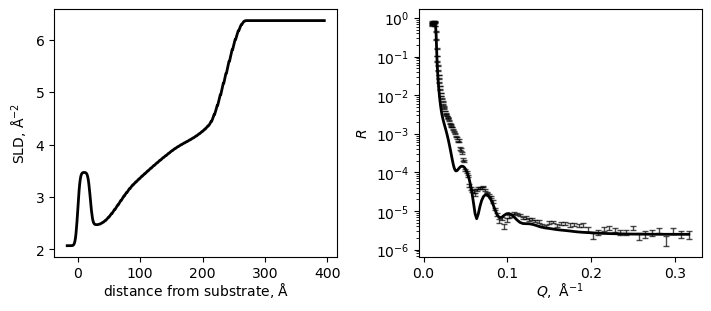

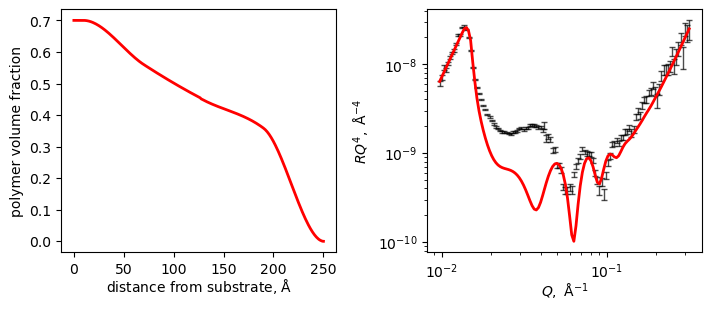

In [5]:
plottools2.graph_plot(objective=objective);
plottools2.graph_plot(objective=objective, orientation='h');
plottools2.graph_plot(objective=objective, orientation='h', vf_plot=True,
                      sld_plot=False, ystyle='rq4', xstyle='log', color='r');

Or together...

In [6]:
objectives = []
for start_vf in [0.1, 0.2, 0.3]:
    objective.model.structure[2].vfsolv.setp(value=start_vf)
    objectives.append(copy.deepcopy(objective))

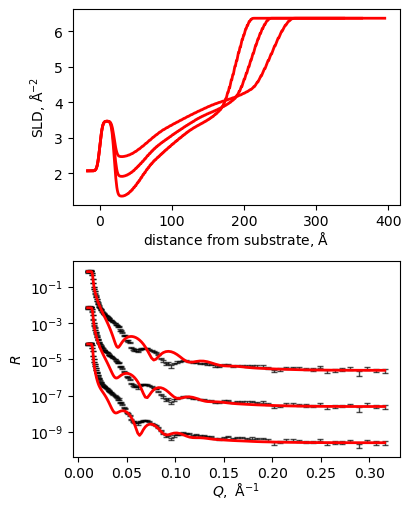

In [7]:
plottools2.graph_plot(objective=objectives, color='r', offset=0.01);
plottools2.graph_plot(objective=objectives, color=plt.cm.viridis, offset=0.01);

You can create reports from single objectives

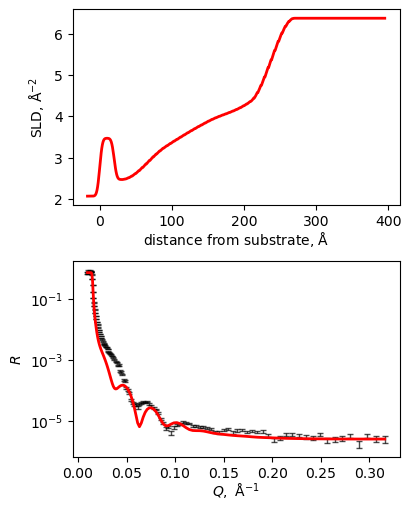

In [8]:
report = objective_processing2.objective_report(objective)
report.process_objective()
plottools2.graph_plot(report=report, color='r');

Or multiple objectives

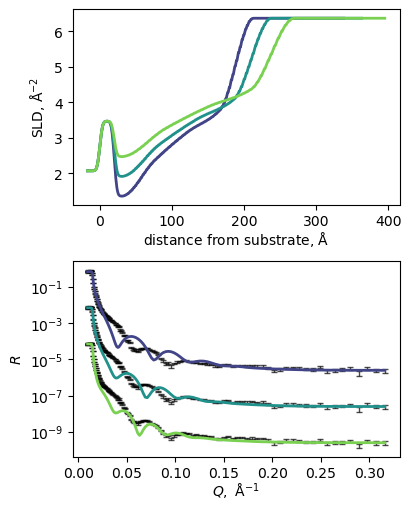

In [9]:
reports = []
for obj in objectives:
    report = objective_processing2.objective_report(obj)
    report.process_objective()
    reports.append(report)

plottools2.graph_plot(report=reports, color=plt.cm.viridis, offset=0.01);

Reports seem silly until it comes to dealing with MCMC results

In [10]:
fitters = []
for obj in objectives:
    fitter = CurveFitter(obj)
    fitter.fit('least_squares')
    fitter.initialise('covar')
    fitter.sample(10)
    fitters.append(fitter)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.08it/s]


Creating reports takes a little while, but afterwards plotting will be fast. Its probably a little too slow. I probably need to do some optimising...

In [11]:
reports = []
for fitter in fitters:
    obj = fitter.objective
    report = objective_processing2.objective_report(obj)
    report.process_objective(fitter.chain[-1])
    reports.append(report)

(<Figure size 400x700 with 4 Axes>,
 [<AxesSubplot:xlabel='distance from substrate, $\\mathrm{\\AA}$', ylabel='polymer volume fraction'>,
  <AxesSubplot:xlabel='distance from substrate, $\\mathrm{\\AA}$', ylabel='SLD, $\\rm{\\AA}^{-2}$'>,
  <AxesSubplot:xlabel='$Q,\\ \\mathrm{\\AA}^{-1}$', ylabel='$R$'>])

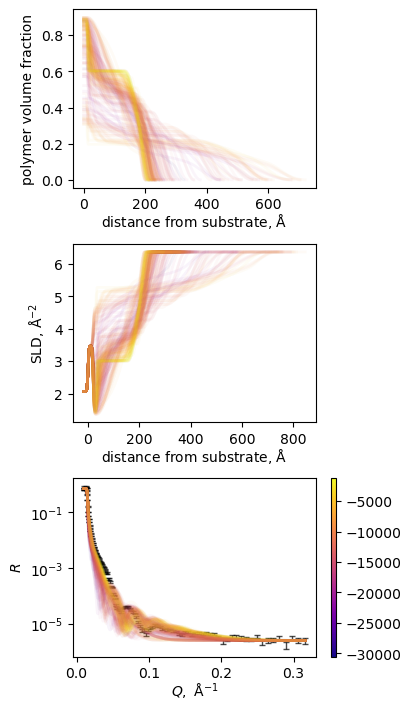

In [12]:
plottools2.graph_plot(report=reports[0], vf_plot=True, color=plt.cm.plasma, cbar=True)

Or many reports

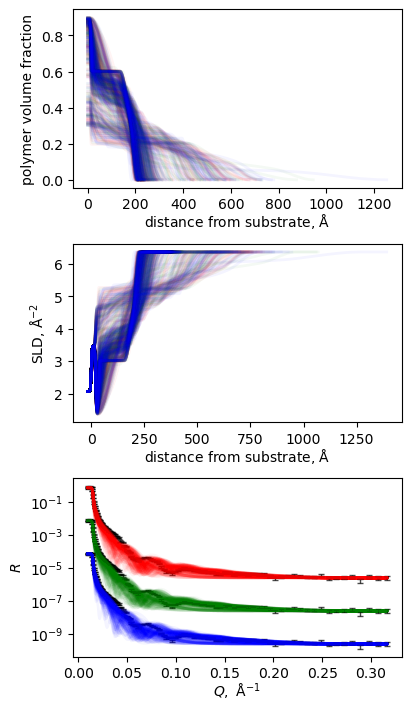

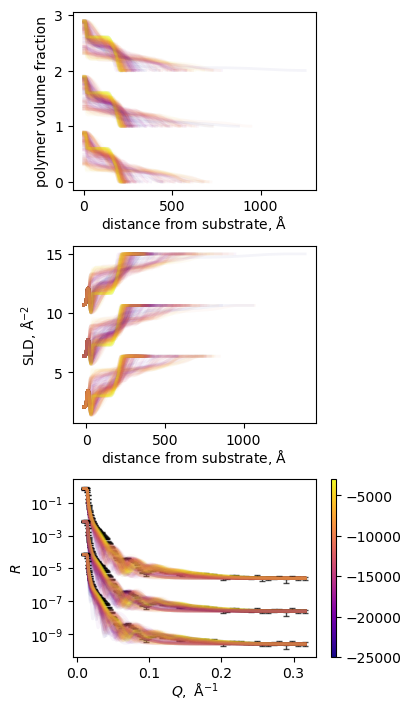

In [13]:
plottools2.graph_plot(report=reports, vf_plot=True, color=['r', 'g', 'b'], offset=0.01)

fig, ax = plottools2.graph_plot(report=reports, vf_plot=True, color=[plt.cm.plasma]*3, offset=0.01, cbar=True,
                      logpost_limits=[-25000, -3000], profile_offset=True)

The features that haven't been implimented yet are multiple objectives (i.e., corefining) and multiple structures (i.e., multiple area model) 